In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [396]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [397]:
def best_output(row):
    # se o downloadTime é diferente de 100 para T2 e T3, ambos os targets completam o download
    if ((row.downloadTimeT2!=100)&(row.downloadTimeT3!=100)):
        # o melhor output será aquele para o qual o downloadTime é menor
        if (row.downloadTimeT2<=row.downloadTimeT3):
            return 0
        else:
            return 1
    
    # se o downloadTime é diferente de 100 apenas para um dos targets, só um deles completa o download
    elif ((row.downloadTimeT2!=100)|(row.downloadTimeT3!=100)):
        # o melhor output será aquele para o qual o downloadTime é diferente de 100
        if (row.downloadTimeT2!=100):
            return 0
        else:
            return 1
        
    # se o downloadTime é igual a 100 para T2 e T3, ambos os targets não completam o download
    elif ((row.downloadTimeT2==100)&(row.downloadTimeT3==100)):
        # o melhor output será aquele para o qual o rxBytes é maior
        if (row.rxBytesT2>=row.rxBytesT3):
            return 0
        else:
            return 1

In [398]:
def download_complete(row, column):
    if (row[column]==0):
        if(row.downloadTimeT2!=100.0):
            return 1
        else:
            return 0
    else:
        if(row.downloadTimeT3!=100.0):
            return 1
        else: 
            return 0

        
def download_time(row, column):
    if ((row[column]==0)&(row.downloadTimeT2<100)):
        return row.downloadTimeT2
    elif ((row[column]==1)&(row.downloadTimeT3<100)):
        return row.downloadTimeT3

    
def throughput(row, column):
    if (row[column]==0):
        tp = (row.rxBytesT2/row.downloadTimeT2)*8/1e6
        return tp
    else:
        tp = (row.rxBytesT3/row.downloadTimeT3)*8/1e6
        return tp

In [399]:
def optimum_choice(row, column):
    if (row[column]==row.best_output):
        return 1
    else:
        return 0

In [400]:
def a2a4rsrp(row):
    if (row.rsrp2>=row.rsrp3):
        return 0
    else:
        return 1

# Sem Shadowing

In [401]:
# importando os datasets
t2 = pd.read_csv('resultados/t2_OkumuraHata_Modificado', delimiter='\t')
t3 = pd.read_csv('resultados/t3_OkumuraHata_Modificado', delimiter='\t')

# garantindo que utilizaremos apenas as sementes presentes nos dois datasets
t2 = t2[t2.nRun.isin(t3.nRun)]
t3 = t3[t3.nRun.isin(t2.nRun)]
t2 = t2.reset_index(drop=True)
t3 = t3.reset_index(drop=True)

In [402]:
# combinando os datasets
data = t2
data = data.drop(['targetCellId', 'downloadTime', 'rxBytes'], axis=1)
data['downloadTimeT2'] = t2.downloadTime
data['downloadTimeT3'] = t3.downloadTime
data['rxBytesT2'] = t2.rxBytes
data['rxBytesT3'] = t3.rxBytes

In [403]:
data['best_output'] = data.apply(best_output, axis=1)
data.head()

,nRun,angle,rsrp1,rsrq1,rsrp2,rsrq2,rsrp3,rsrq3,previousrsrp1,previousrsrq1,previousrsrp2,previousrsrq2,previousrsrp3,previousrsrq3,downloadTimeT2,downloadTimeT3,rxBytesT2,rxBytesT3,best_output
0,1,-54.57300,-91.4534,-4.36266,-96.7808,-9.69006,-102.9210,-15.8302,-91.2293,-4.27418,-96.9354,-9.9803,-102.8840,-15.9288,37.000,100.0000,15728640,10170752,0
1,2,-24.03920,-91.2610,-4.30386,-97.6844,-10.72730,-100.5270,-13.5702,-91.0186,-4.21518,-97.8386,-11.0352,-100.5620,-13.7581,46.809,100.0000,15728640,15106984,0
2,3,-20.04290,-91.3627,-4.33647,-97.8093,-10.78300,-100.2320,-13.2054,-91.1204,-4.24653,-97.9572,-11.0833,-100.2760,-13.4026,48.781,42.7271,15728640,15728640,1
3,4,-49.51330,-91.3211,-4.33040,-96.8836,-9.89290,-102.4740,-15.4829,-91.0927,-4.24175,-97.0454,-10.1945,-102.4470,-15.5956,38.277,100.0000,15728640,10490760,0
4,5,-9.37145,-91.3008,-4.29974,-98.4062,-11.40520,-99.5329,-12.5319,-91.0547,-4.21276,-98.5311,-11.6892,-99.6079,-12.7659,100.000,39.6510,15560208,15728640,1


In [404]:
teste = data[data.nRun>800]
data = data[data.nRun<=800]

### Estratégia 1

In [405]:
# A: Download Completo ou Incompleto (para todas as amostras)
nn1_a_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]

# NN A para T2
nn1_a0_output = (data.downloadTimeT2<100).astype(int)
nn1_a0 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1, validation_fraction=0.25)
nn1_a0.fit(nn1_a_input.as_matrix(), nn1_a0_output);

# NN A para T3
nn1_a1_output = (data.downloadTimeT3<100).astype(int)
nn1_a1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1, validation_fraction=0.25)
nn1_a1.fit(nn1_a_input.as_matrix(), nn1_a1_output);

In [406]:
print ((nn1_a0.predict(nn1_a_input)==(data.downloadTimeT2!=100).astype(int)).sum()/data.shape[0])
print ((nn1_a1.predict(nn1_a_input)==(data.downloadTimeT3!=100).astype(int)).sum()/data.shape[0])

0.9975
0.99875


In [407]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)
nn1_b_input = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)][['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
# NN B para T2
nn1_b0_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2
nn1_b0 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5), random_state=1, validation_fraction=0.1)
nn1_b0.fit(nn1_b_input.as_matrix(), nn1_b0_output);
# NN B para T3
nn1_b1_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3
nn1_b1 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5), random_state=1, validation_fraction=0.1)
nn1_b1.fit(nn1_b_input.as_matrix(), nn1_b1_output);

In [408]:
from sklearn.metrics import mean_squared_error
print (mean_squared_error(nn1_b0.predict(nn1_b_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2))
print (mean_squared_error(nn1_b1.predict(nn1_b_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3))

0.286826277776
0.124935778445


In [409]:
def nn1_func(row):
    nn1_input = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    # Nível 1A
    # se o downloadTime previsto é menor que 100 para T2 e T3, ambos os targets completam o download
    if ((nn1_a0.predict(nn1_input)==1)&(nn1_a1.predict(nn1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        if (nn1_b0.predict(nn1_input)<=nn1_b1.predict(nn1_input)):
            return 0
        else:
            return 1
    
    # se o downloadTime previsto é menor que 100 apenas para um dos targets, só um deles completa o download
    elif ((nn1_a0.predict(nn1_input)==1)|(nn1_a1.predict(nn1_input)==1)):
        # o melhor output será aquele para o qual o downloadTime previsto é menor que 100
        if (nn1_a0.predict(nn1_input)==1):
            return 0
        else:
            return 1

In [410]:
((nn1_a_input.apply(nn1_func, axis=1)==data.best_output).sum())/data.best_output.size

0.99875000000000003

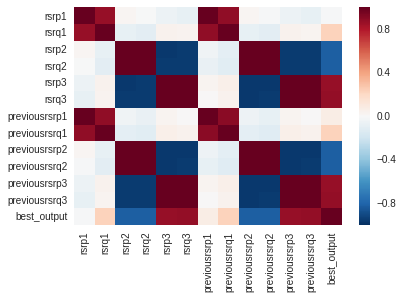

In [411]:
import seaborn as sns
features = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3','best_output']]
sns.heatmap(features.corr())

### Estratégia 2

In [412]:
# A: Download Completo ou Incompleto (para todas as amostras)

# NN A para T2
nn2_a0_input = data[['rsrp2','rsrq2']]
nn2_a0_output = (data.downloadTimeT2<100).astype(int)
nn2_a0 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1, validation_fraction=0.25)
nn2_a0.fit(nn2_a0_input.as_matrix(), nn2_a0_output);

# NN A para T3
nn2_a1_input = data[['rsrp3','rsrq3']]
nn2_a1_output = (data.downloadTimeT3<100).astype(int)
nn2_a1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1, validation_fraction=0.25)
nn2_a1.fit(nn2_a1_input.as_matrix(), nn2_a1_output);

In [413]:
print ((nn2_a0.predict(nn2_a0_input)==(data.downloadTimeT2!=100).astype(int)).sum()/data.shape[0])
print ((nn2_a1.predict(nn2_a1_input)==(data.downloadTimeT3!=100).astype(int)).sum()/data.shape[0])

0.9975
0.99875


In [414]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)

# NN B para T2
nn2_b0_input = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)][['rsrp2','rsrq2']]
nn2_b0_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2
nn2_b0 = MLPRegressor(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5), random_state=1, validation_fraction=0.1)
nn2_b0.fit(nn2_b0_input.as_matrix(), nn2_b0_output);
# NN B para T3
nn2_b1_input = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)][['rsrp3','rsrq3']]
nn2_b1_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3
nn2_b1 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5), random_state=1, validation_fraction=0.1)
nn2_b1.fit(nn2_b1_input.as_matrix(), nn2_b1_output);

In [415]:
from sklearn.metrics import mean_squared_error
print (mean_squared_error(nn2_b0.predict(nn2_b0_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2))
print (mean_squared_error(nn2_b1.predict(nn2_b1_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3))

1.03581198586
0.139856680391


In [416]:
def nn2_func(row):
    nn2_a0_input = row[['rsrp2','rsrq2']].values.reshape(1, -1)
    nn2_a1_input = row[['rsrp3','rsrq3']].values.reshape(1, -1)
    
    # Nível 1A
    # se ambos os targets completam o download
    if ((nn2_a0.predict(nn2_a0_input)==1)&(nn2_a1.predict(nn2_a1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        nn2_b0_input = nn2_a0_input
        nn2_b1_input = nn2_a0_input
        if (nn2_b0.predict(nn2_b0_input)<=nn2_b1.predict(nn2_b1_input)):
            return 0
        else:
            return 1
    
    # se apenas um dos targets completa o download
    elif ((nn2_a0.predict(nn2_a0_input)==1)|(nn2_a1.predict(nn2_a1_input)==1)):
        # o melhor output será aquele que completa o download, segundo a previsão
        if (nn2_a0.predict(nn2_a0_input)==1):
            return 0
        else:
            return 1

In [417]:
((data.apply(nn2_func, axis=1)==data.best_output).sum())/data.best_output.size

0.99875000000000003

### Estratégia 3

In [418]:
nn3_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
nn3_output = data.best_output

nn3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5), random_state=1, validation_fraction=0.25)

nn3.fit(nn3_input.as_matrix(), nn3_output)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.25, verbose=False,
       warm_start=False)

In [419]:
def nn3_func(row):
    nn3_input_ = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    return nn3.predict(nn3_input_)[0]

In [420]:
((data.apply(nn3_func, axis=1)==data.best_output).sum())/data.best_output.size

0.99875000000000003

In [421]:
teste['best_choice_download_complete'] = teste.apply(lambda x: download_complete(x, column='best_output'), axis=1)
teste['best_choice_download_time'] = teste.apply(lambda x: download_time(x, column='best_output'), axis=1)
teste['best_choice_throughput'] = teste.apply(lambda x: throughput(x, column='best_output'), axis=1)

In [422]:
teste['nn1'] = teste.apply(nn1_func, axis=1)
teste['nn1_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn1'), axis=1)
teste['nn1_download_time'] = teste.apply(lambda x: download_time(x, column='nn1'), axis=1)
teste['nn1_throughput'] = teste.apply(lambda x: throughput(x, column='nn1'), axis=1)

In [423]:
teste['nn2'] = teste.apply(nn2_func, axis=1)
teste['nn2_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn2'), axis=1)
teste['nn2_download_time'] = teste.apply(lambda x: download_time(x, column='nn2'), axis=1)
teste['nn2_throughput'] = teste.apply(lambda x: throughput(x, column='nn2'), axis=1)

In [424]:
teste['nn3'] = teste.apply(nn3_func, axis=1)
teste['nn3_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn3'), axis=1)
teste['nn3_download_time'] = teste.apply(lambda x: download_time(x, column='nn3'), axis=1)
teste['nn3_throughput'] = teste.apply(lambda x: throughput(x, column='nn3'), axis=1)

### Estratégias Clássicas

In [425]:
teste['a2a4rsrp'] = teste.apply(a2a4rsrp, axis=1)
teste['a2a4rsrp_download_complete'] = teste.apply(lambda x: download_complete(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_download_time'] = teste.apply(lambda x: download_time(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_throughput'] = teste.apply(lambda x: throughput(x, column='a2a4rsrp'), axis=1)

In [426]:
# importando os datasets com dados de simulações de outras duas estratégias clássicas
a3rsrp = pd.read_csv('resultados/A3RSRP_OkumuraHata_Modificado', delimiter='\t')
a2a4rsrq = pd.read_csv('resultados/A2A4RSRQ_OkumuraHata_Modificado', delimiter='\t')
a3rsrp_teste = a3rsrp[a3rsrp.nRun>800]
a2a4rsrq_teste = a2a4rsrq[a2a4rsrq.nRun>800]

def func(row):
    if (row.downloadTime<100):
        return row.downloadTime
    
teste['a3rsrp_download_complete'] = (a3rsrp_teste.downloadTime<100).astype(int)
teste['a3rsrp_download_time'] = a3rsrp_teste.apply((lambda x: func(x)), axis=1)
teste['a3rsrp_throughput'] = (a3rsrp_teste.rxBytes/a3rsrp_teste.downloadTime)*8/1e6

teste['a2a4rsrq_download_complete'] = (a2a4rsrq_teste.downloadTime<100).astype(int)
teste['a2a4rsrq_download_time'] = a2a4rsrq_teste.apply((lambda x: func(x)), axis=1)
teste['a2a4rsrq_throughput'] = (a2a4rsrq_teste.rxBytes/a2a4rsrq_teste.downloadTime)*8/1e6

#### Resultados - Sem Shadowing

In [427]:
estrategias = ['a2a4rsrp', 'a2a4rsrq', 'a3rsrp', 'nn1', 'nn2', 'nn3', 'best_choice']

results_ss = {}

for estrategia in estrategias:
    #print("\n\n", estrategia)
    #print("- Geral:")
    #print("Percentual de Downloads Completos: ", (teste[estrategia+"_download_complete"].sum()/teste.index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[estrategia+"_throughput"].mean(), "Mbps")
    #print("- Para a região central [-30,0]:")
    #print("Percentual de Downloads Completos: ", (teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(), "Mbps")
    results_ss[estrategia] = []
    results_ss[estrategia].append(round((teste[estrategia+"_download_complete"].sum()/teste.index.size)*100,1))
    results_ss[estrategia].append(round(teste[estrategia+"_download_time"].mean(),1))
    results_ss[estrategia].append(round(teste[estrategia+"_throughput"].mean(),1))
    results_ss[estrategia].append(round((teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100,1))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(),1))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(),1))

#### Resultados para o conjunto de teste - OkumuraHata sem shadowing

#### Geral

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][0]}}|{{results_ss['a2a4rsrq'][0]}}|{{results_ss['a3rsrp'][0]}}|{{results_ss['nn1'][0]}}|{{results_ss['nn2'][0]}}|{{results_ss['nn3'][0]}}|{{results_ss['best_choice'][0]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][1]}}|{{results_ss['a2a4rsrq'][1]}}|{{results_ss['a3rsrp'][1]}}|{{results_ss['nn1'][1]}}|{{results_ss['nn2'][1]}}|{{results_ss['nn3'][1]}}|{{results_ss['best_choice'][1]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][2]}}|{{results_ss['a2a4rsrq'][2]}}|{{results_ss['a3rsrp'][2]}}|{{results_ss['nn1'][2]}}|{{results_ss['nn2'][2]}}|{{results_ss['nn3'][2]}}|{{results_ss['best_choice'][2]}}|

#### Para a região central [-30,0]

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][3]}}|{{results_ss['a2a4rsrq'][3]}}|{{results_ss['a3rsrp'][3]}}|{{results_ss['nn1'][3]}}|{{results_ss['nn2'][3]}}|{{results_ss['nn3'][3]}}|{{results_ss['best_choice'][3]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][4]}}|{{results_ss['a2a4rsrq'][4]}}|{{results_ss['a3rsrp'][4]}}|{{results_ss['nn1'][4]}}|{{results_ss['nn2'][4]}}|{{results_ss['nn3'][4]}}|{{results_ss['best_choice'][4]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][5]}}|{{results_ss['a2a4rsrq'][5]}}|{{results_ss['a3rsrp'][5]}}|{{results_ss['nn1'][5]}}|{{results_ss['nn2'][5]}}|{{results_ss['nn3'][5]}}|{{results_ss['best_choice'][5]}}|

# Com Shadowing

In [428]:
t2 = pd.read_csv('resultados/t2_OhBuildings_ComShadowing_Modificado', delimiter='\t')
t3 = pd.read_csv('resultados/t3_OhBuildings_ComShadowing_Modificado', delimiter='\t')

In [429]:
t2 = t2[t2.nRun.isin(t3.nRun)]
t2.reset_index(drop=True, inplace=True)
t3 = t3[t3.nRun.isin(t2.nRun)]
t3.reset_index(drop=True, inplace=True)

In [430]:
a3rsrp = pd.read_csv('resultados/A3RSRP_OhBuildings_ComShadowing_Modificado', delimiter='\t')
a2a4rsrq = pd.read_csv('resultados/A2A4RSRQ_OhBuildings_ComShadowing_Modificado', delimiter='\t')

In [431]:
t2_runs = t2.nRun
t3_runs = t3.nRun
a3rsrp_runs = a3rsrp.nRun
a2a4rsrq_runs = a2a4rsrq.nRun
valid_results = t2[t2.rsrp1==t3.rsrp1].nRun
valid_runs = set(t2_runs).intersection(t3_runs).intersection(a3rsrp_runs).intersection(a2a4rsrq_runs).intersection(valid_results)

In [432]:
t2 = t2[t2.nRun.isin(valid_runs)]
t3 = t3[t3.nRun.isin(valid_runs)]
a3rsrp = a3rsrp[a3rsrp.nRun.isin(valid_runs)]
a2a4rsrq = a2a4rsrq[a2a4rsrq.nRun.isin(valid_runs)]

t2.reset_index(drop=True, inplace=True)
t3.reset_index(drop=True, inplace=True)
a3rsrp.reset_index(drop=True, inplace=True)
a2a4rsrq.reset_index(drop=True, inplace=True)

In [433]:
# combinando os datasets
data = t2
data = data.drop(['targetCellId', 'downloadTime', 'rxBytes'], axis=1)
data['downloadTimeT2'] = t2.downloadTime
data['downloadTimeT3'] = t3.downloadTime
data['rxBytesT2'] = t2.rxBytes
data['rxBytesT3'] = t3.rxBytes

In [434]:
data['best_output'] = data.apply(best_output, axis=1)

In [435]:
teste = data[(data.nRun>800) & (data.nRun<=1000)]
data = data[data.nRun<=800]

In [436]:
a3rsrp_teste = a3rsrp[(a3rsrp.nRun>800) & (a3rsrp.nRun<=1000)]
a2a4rsrq_teste = a2a4rsrq[(a2a4rsrq.nRun>800) & (a3rsrp.nRun<=1000)]

### Estratégia 1

In [482]:
# A: Download Completo ou Incompleto (para todas as amostras)
nn1_a_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]

# NN A para T2
nn1_a0_output = (data.downloadTimeT2<100).astype(int)
nn1_a0 = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(), random_state=1, validation_fraction=0.25)
nn1_a0.fit(nn1_a_input.as_matrix(), nn1_a0_output);

# NN A para T3
nn1_a1_output = (data.downloadTimeT3<100).astype(int)
nn1_a1 = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(), random_state=1, validation_fraction=0.25)
nn1_a1.fit(nn1_a_input.as_matrix(), nn1_a1_output);

In [483]:
print ((nn1_a0.predict(nn1_a_input)==(data.downloadTimeT2!=100).astype(int)).sum()/data.shape[0])
print ((nn1_a1.predict(nn1_a_input)==(data.downloadTimeT3!=100).astype(int)).sum()/data.shape[0])

0.901639344262
0.799180327869


In [439]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)
nn1_b_input = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)][['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
# NN B para T2
nn1_b0_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2
nn1_b0 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1, validation_fraction=0.1)
nn1_b0.fit(nn1_b_input.as_matrix(), nn1_b0_output);
# NN B para T3
nn1_b1_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3
nn1_b1 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1, validation_fraction=0.1)
nn1_b1.fit(nn1_b_input.as_matrix(), nn1_b1_output);

In [440]:
from sklearn.metrics import mean_squared_error
print (mean_squared_error(nn1_b0.predict(nn1_b_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2))
print (mean_squared_error(nn1_b1.predict(nn1_b_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3))

13.4092405802
111.440473006


In [441]:
# C: RxBytes (para amostras em que ambos os targets não completam o download)
nn1_c_input = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)][['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
# NN B para T2
nn1_c0_output = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT2
nn1_c0 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1, validation_fraction=0.1)
nn1_c0.fit(nn1_c_input.as_matrix(), nn1_c0_output);
# NN B para T3
nn1_c1_output = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT3
nn1_c1 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1, validation_fraction=0.1)
nn1_c1.fit(nn1_c_input.as_matrix(), nn1_c1_output);

In [442]:
from sklearn.metrics import mean_squared_error
print (mean_squared_error(nn1_c0.predict(nn1_c_input),data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT2))
print (mean_squared_error(nn1_c1.predict(nn1_c_input),data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT3))

1.13056481944e+13
1.33244513315e+13


In [443]:
def nn1_func(row):
    nn1_input = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    # Nível 1A
    # se o downloadTime previsto é menor que 100 para T2 e T3, ambos os targets completam o download
    if ((nn1_a0.predict(nn1_input)==1)&(nn1_a1.predict(nn1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        if (nn1_b0.predict(nn1_input)<=nn1_b1.predict(nn1_input)):
            return 0
        else:
            return 1
    
    # se o downloadTime previsto é menor que 100 apenas para um dos targets, só um deles completa o download
    elif ((nn1_a0.predict(nn1_input)==1)|(nn1_a1.predict(nn1_input)==1)):
        # o melhor output será aquele para o qual o downloadTime previsto é menor que 100
        if (nn1_a0.predict(nn1_input)==1):
            return 0
        else:
            return 1
        
    # se o downloadTime previsto é menor que 100 para ambos os targets
    elif ((nn1_a0.predict(nn1_input)==0)&(nn1_a1.predict(nn1_input)==0)):
        # o melhor output será aquele para o qual o rxBytes previsto é maior
        if (nn1_c0.predict(nn1_input)>=nn1_c1.predict(nn1_input)):
            return 0
        else:
            return 1        

In [444]:
((nn1_a_input.apply(nn1_func, axis=1)==data.best_output).sum())/data.best_output.size

0.77663934426229508

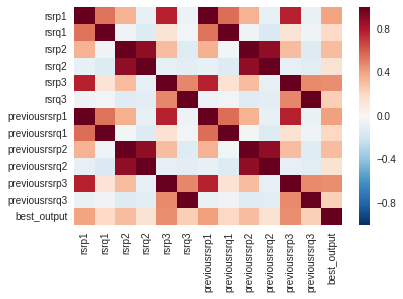

In [445]:
import seaborn as sns
features = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3','best_output']]
sns.heatmap(features.corr())

### Estratégia 2

In [484]:
data_norm = (data - data.mean()) / (data.max() - data.min())

In [501]:
# A: Download Completo ou Incompleto (para todas as amostras)

# NN A para T2
nn2_a0_input = data[['rsrp2','rsrq2']]
nn2_a0_output = (data.downloadTimeT2<100).astype(int)
nn2_a0 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,15), random_state=1, validation_fraction=0.25)
nn2_a0.fit(nn2_a0_input.as_matrix(), nn2_a0_output);

# NN A para T3
nn2_a1_input = data_norm[['rsrp3','rsrq3']]
nn2_a1_output = (data.downloadTimeT3<100).astype(int)
nn2_a1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,15), random_state=1, validation_fraction=0.25)
nn2_a1.fit(nn2_a1_input.as_matrix(), nn2_a1_output);


print ((nn2_a0.predict(nn2_a0_input)==(data.downloadTimeT2!=100).astype(int)).sum()/data.shape[0])
print ((nn2_a1.predict(nn2_a1_input)==(data.downloadTimeT3!=100).astype(int)).sum()/data.shape[0])

0.743852459016
0.737704918033


In [502]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)

# NN B para T2
nn2_b0_input = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)][['rsrp2','rsrq2']]
nn2_b0_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2
nn2_b0 = MLPRegressor(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(20,15), random_state=1, validation_fraction=0.1)
nn2_b0.fit(nn2_b0_input.as_matrix(), nn2_b0_output);
# NN B para T3
nn2_b1_input = data_norm[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)][['rsrp3','rsrq3']]
nn2_b1_output = data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3
nn2_b1 = MLPRegressor(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(20,15), random_state=1, validation_fraction=0.1)
nn2_b1.fit(nn2_b1_input.as_matrix(), nn2_b1_output);

from sklearn.metrics import mean_squared_error
print (mean_squared_error(nn2_b0.predict(nn2_b0_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT2))
print (mean_squared_error(nn2_b1.predict(nn2_b1_input),data[(data.downloadTimeT2!=100)&(data.downloadTimeT3!=100)].downloadTimeT3))

62.8248017321
175.255961131


In [448]:
# C: Bytes Recebidos (para amostras em que ambos os targets não completam o download)

# NN C para T2
nn2_c0_input = data[(data.downloadTimeT2==100)&(data.downloadTimeT3==100)][['rsrp2','rsrq2']]
nn2_c0_output = data[(data.downloadTimeT2==100)&(data.downloadTimeT3==100)].rxBytesT2
nn2_c0 = MLPRegressor(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(), random_state=1, validation_fraction=0.3)
nn2_c0.fit(nn2_c0_input.as_matrix(), nn2_c0_output);
# NN C para T3
nn2_c1_input = data[(data.downloadTimeT2==100)&(data.downloadTimeT3==100)][['rsrp3','rsrq3']]
nn2_c1_output = data[(data.downloadTimeT2==100)&(data.downloadTimeT3==100)].rxBytesT3
nn2_c1 = MLPRegressor(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(), random_state=1, validation_fraction=0.3)
nn2_c1.fit(nn2_c1_input.as_matrix(), nn2_c1_output);

from sklearn.metrics import mean_squared_error
print (mean_squared_error(nn2_c0.predict(nn2_c0_input),data[(data.downloadTimeT2==100)&(data.downloadTimeT3==100)].rxBytesT2))
print (mean_squared_error(nn2_c1.predict(nn2_c1_input),data[(data.downloadTimeT2==100)&(data.downloadTimeT3==100)].rxBytesT3))

1.82493041031e+13
1.81942807837e+13


In [449]:
def nn2_func(row):
    nn2_a0_input = row[['rsrp2','rsrq2']].values.reshape(1, -1)
    nn2_a1_input = row[['rsrp3','rsrq3']].values.reshape(1, -1)
    
    # Nível 1A
    # se ambos os targets completam o download
    if ((nn2_a0.predict(nn2_a0_input)==1)&(nn2_a1.predict(nn2_a1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        nn2_b0_input = nn2_a0_input
        nn2_b1_input = nn2_a0_input
        if (nn2_b0.predict(nn2_b0_input)<=nn2_b1.predict(nn2_b1_input)):
            return 0
        else:
            return 1
    
    # se apenas um dos targets completa o download
    elif ((nn2_a0.predict(nn2_a0_input)==1)|(nn2_a1.predict(nn2_a1_input)==1)):
        # o melhor output será aquele que completa o download, segundo a previsão
        if (nn2_a0.predict(nn2_a0_input)==1):
            return 0
        else:
            return 1
        
    # se apenas nenhum dos targets completa o download
    elif ((nn2_a0.predict(nn2_a0_input)==0)&(nn2_a1.predict(nn2_a1_input)==0)):
        # o melhor output será aquele para o qual o rxBytes previsto é maior
        nn2_c0_input = nn2_a0_input
        nn2_c1_input = nn2_a0_input
        if (nn2_c0.predict(nn2_c0_input)>=nn2_c1.predict(nn2_c1_input)):
            return 0
        else:
            return 1        
        
((data.apply(nn2_func, axis=1)==data.best_output).sum())/data.best_output.size

0.58401639344262291

### Estratégia 3

In [450]:
nn3_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
nn3_output = data.best_output

nn3 = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(), random_state=1, validation_fraction=0.3)

nn3.fit(nn3_input.as_matrix(), nn3_output)

def nn3_func(row):
    nn3_input_ = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    return nn3.predict(nn3_input_)[0]

(nn3.predict(nn3_input)==data.best_output).sum()/data.best_output.size

0.88729508196721307

In [451]:
teste['best_choice_download_complete'] = teste.apply(lambda x: download_complete(x, column='best_output'), axis=1)
teste['best_choice_download_time'] = teste.apply(lambda x: download_time(x, column='best_output'), axis=1)
teste['best_choice_throughput'] = teste.apply(lambda x: throughput(x, column='best_output'), axis=1)

In [452]:
teste['nn1'] = teste.apply(nn1_func, axis=1)
teste['nn1_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn1'), axis=1)
teste['nn1_download_time'] = teste.apply(lambda x: download_time(x, column='nn1'), axis=1)
teste['nn1_throughput'] = teste.apply(lambda x: throughput(x, column='nn1'), axis=1)

In [453]:
teste['nn2'] = teste.apply(nn2_func, axis=1)
teste['nn2_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn2'), axis=1)
teste['nn2_download_time'] = teste.apply(lambda x: download_time(x, column='nn2'), axis=1)
teste['nn2_throughput'] = teste.apply(lambda x: throughput(x, column='nn2'), axis=1)

In [454]:
teste['nn3'] = teste.apply(nn3_func, axis=1)
teste['nn3_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn3'), axis=1)
teste['nn3_download_time'] = teste.apply(lambda x: download_time(x, column='nn3'), axis=1)
teste['nn3_throughput'] = teste.apply(lambda x: throughput(x, column='nn3'), axis=1)

### Estratégias Clássicas

In [455]:
teste['a2a4rsrp'] = teste.apply(a2a4rsrp, axis=1)
teste['a2a4rsrp_download_complete'] = teste.apply(lambda x: download_complete(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_download_time'] = teste.apply(lambda x: download_time(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_throughput'] = teste.apply(lambda x: throughput(x, column='a2a4rsrp'), axis=1)

In [456]:
def func(row):
    if (row.downloadTime<100):
        return row.downloadTime
    
teste['a3rsrp_download_complete'] = (a3rsrp_teste.downloadTime<100).astype(int)
teste['a3rsrp_download_time'] = a3rsrp_teste.apply((lambda x: func(x)), axis=1)
teste['a3rsrp_throughput'] = (a3rsrp_teste.rxBytes/a3rsrp_teste.downloadTime)*8/1e6

teste['a2a4rsrq_download_complete'] = (a2a4rsrq_teste.downloadTime<100).astype(int)
teste['a2a4rsrq_download_time'] = a2a4rsrq_teste.apply((lambda x: func(x)), axis=1)
teste['a2a4rsrq_throughput'] = (a2a4rsrq_teste.rxBytes/a2a4rsrq_teste.downloadTime)*8/1e6

#### Resultados - Sem Shadowing

In [457]:
estrategias = ['a2a4rsrp', 'a2a4rsrq', 'a3rsrp', 'nn1', 'nn2', 'nn3', 'best_choice']

results_ss = {}

for estrategia in estrategias:
    #print("\n\n", estrategia)
    #print("- Geral:")
    #print("Percentual de Downloads Completos: ", (teste[estrategia+"_download_complete"].sum()/teste.index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[estrategia+"_throughput"].mean(), "Mbps")
    #print("- Para a região central [-30,0]:")
    #print("Percentual de Downloads Completos: ", (teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(), "Mbps")
    results_ss[estrategia] = []
    results_ss[estrategia].append(round((teste[estrategia+"_download_complete"].sum()/teste.index.size)*100,1))
    results_ss[estrategia].append(round(teste[estrategia+"_download_time"].mean(),1))
    results_ss[estrategia].append(round(teste[estrategia+"_throughput"].mean(),1))
    results_ss[estrategia].append(round((teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100,1))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(),1))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(),1))

#### Resultados para o conjunto de teste - OhBuildings com shadowing

#### Geral

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][0]}}|{{results_ss['a2a4rsrq'][0]}}|{{results_ss['a3rsrp'][0]}}|{{results_ss['nn1'][0]}}|{{results_ss['nn2'][0]}}|{{results_ss['nn3'][0]}}|{{results_ss['best_choice'][0]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][1]}}|{{results_ss['a2a4rsrq'][1]}}|{{results_ss['a3rsrp'][1]}}|{{results_ss['nn1'][1]}}|{{results_ss['nn2'][1]}}|{{results_ss['nn3'][1]}}|{{results_ss['best_choice'][1]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][2]}}|{{results_ss['a2a4rsrq'][2]}}|{{results_ss['a3rsrp'][2]}}|{{results_ss['nn1'][2]}}|{{results_ss['nn2'][2]}}|{{results_ss['nn3'][2]}}|{{results_ss['best_choice'][2]}}|

#### Para a região central [-30,0]

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][3]}}|{{results_ss['a2a4rsrq'][3]}}|{{results_ss['a3rsrp'][3]}}|{{results_ss['nn1'][3]}}|{{results_ss['nn2'][3]}}|{{results_ss['nn3'][3]}}|{{results_ss['best_choice'][3]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][4]}}|{{results_ss['a2a4rsrq'][4]}}|{{results_ss['a3rsrp'][4]}}|{{results_ss['nn1'][4]}}|{{results_ss['nn2'][4]}}|{{results_ss['nn3'][4]}}|{{results_ss['best_choice'][4]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][5]}}|{{results_ss['a2a4rsrq'][5]}}|{{results_ss['a3rsrp'][5]}}|{{results_ss['nn1'][5]}}|{{results_ss['nn2'][5]}}|{{results_ss['nn3'][5]}}|{{results_ss['best_choice'][5]}}|